# Mounting Drive and Importing Libraries

In [108]:
import os
import pandas as pd
import numpy as np

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Uploading the Train-Test Data

In [110]:
folder_path = '/content/drive/My Drive/titanic_ml/'

train_file='train.csv'
train_path= os.path.join(folder_path, train_file)
test_file='test.csv'
test_path= os.path.join(folder_path, test_file)

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print ("Setup Complete")

Setup Complete


In [124]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#Selecting the Features and Target

In [112]:
from sklearn.model_selection import train_test_split

y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch"]
X=train_data[features]

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Select categorical columns
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

#Loading test data
X_test=test_data[my_cols].copy()


#Preprocessing the data using Pipelines

In [113]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

#Defining a Model

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

#model = RandomForestRegressor(n_estimators=100, random_state=0)
model = RandomForestClassifier(n_estimators=500, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model
final_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
#y_pred is rounded so that both Binary Class Predicting Models (which return a floating value) and Direct Class Predicting Models can be used
y_pred = np.round(final_pipeline.predict(X_valid))


In [121]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Assuming X and y represent your feature matrix and target variable, respectively
# Apply cross-validation
scores = np.round(cross_val_score(final_pipeline, X, y, cv=5))  # cv=5 specifies 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

Cross-Validation Scores: [1. 1. 1. 1. 1.]


#Accuracy and Prediction Heatmap

F1 Score:72.86821705426357 %


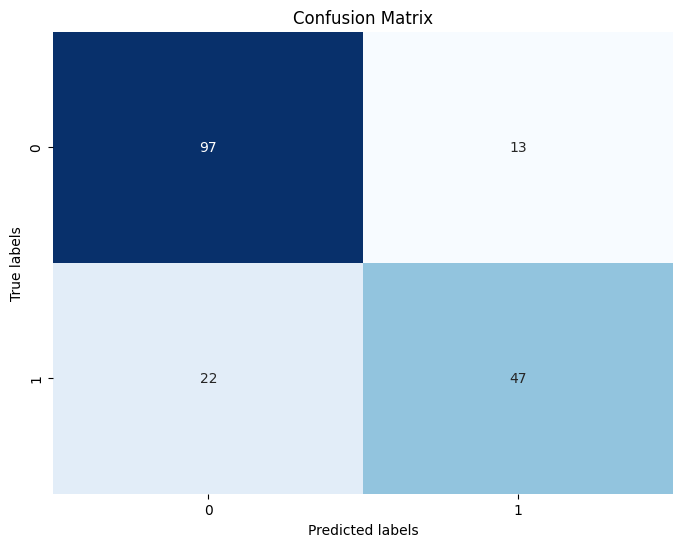

In [123]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate F1 score
f1 = f1_score(y_valid, y_pred)
print(f"F1 Score:{(f1*100)} %")

# Construct the confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

#Applying Model on Test Data

In [117]:
# Preprocessing of test data, fit model
preds_test = final_pipeline.predict(X_test)

In [125]:
# Save test predictions to file
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': preds_test})

output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [126]:
submission_file='submission.csv'
submission_path= os.path.join(folder_path, submission_file)
output.to_csv(submission_path, index=False)
print("Submission was successfully saved hehe!")

Submission was successfully saved hehe!
